# Classification Origin

Papers:

https://www.semanticscholar.org/paper/Music-and-Geography%3A-Content-Description-of-Musical-G%C3%B3mez-Haro/4d48f2eaefc6a8336149e4cca1c5d2264969f223#paper-topics
https://www.geographyrealm.com/the-geography-of-music/
https://www.cambridge.org/core/journals/organised-sound/article/marsyas-a-framework-for-audio-analysis/43A5D9BCB0F7BB439E1D4D1FF4B563C2
https://archive.ics.uci.edu/dataset/315/geographical+original+of+music



In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.over_sampling import SMOTE

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from shapely.geometry import Point
#import folium
#from folium.plugins import MarkerCluster
from pytube import YouTube
import librosa
#import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from datetime import datetime, timezone
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import catboost as cb
from sklearn.metrics import ConfusionMatrixDisplay




In [3]:
music_origin_data = pd.read_csv('./data/kaggle/Music_origin.csv')
music_origin_cr_data = pd.read_csv('./data/kaggle/Music_origin_chromatic.csv')
gdf_bondaries = gpd.read_file('./data/countries/world-administrative-boundaries.shp')

music_origin_data.drop('Unnamed: 0',axis=1,inplace=True)
music_origin_cr_data.drop('Unnamed: 0',axis=1,inplace=True)

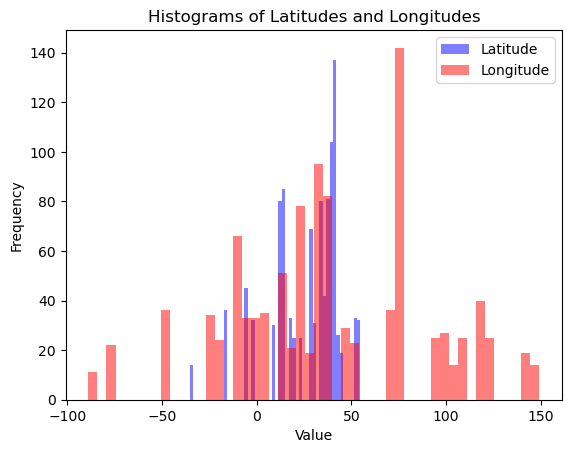

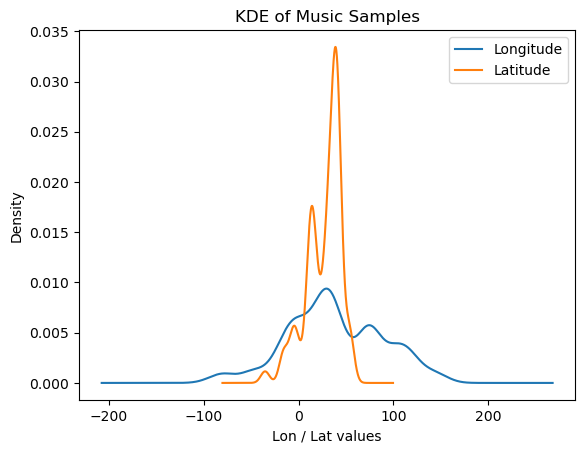

In [4]:
with open('./data/default_features_1059_tracks.txt', newline='') as inputfile:
    data = list(csv.reader(inputfile))

plt.hist(music_origin_data["Latitude"], bins=50, alpha=0.5, color='blue', label='Latitude')
plt.hist(music_origin_data["Longitude"], bins=50, alpha=0.5, color='red', label='Longitude')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histograms of Latitudes and Longitudes')
plt.savefig('./images/02_hist_lat_lon.png')
plt.show()



music_origin_data[["Longitude","Latitude"]].plot.kde()
plt.xlabel('Lon / Lat values')
plt.title('KDE of Music Samples')
plt.savefig('./images/03_KDE_lat_lon.png')
plt.show()

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\claud\AppData\Local\Temp\ipykernel_2952\1652072319.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearest_polygon_idx = gdf_bondaries.geometry.distance(point_geom).idxmin()
C:\Users\claud\AppData\Local\Temp\ipykernel_2952\1652072319.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearest_polygon_attributes['geometry'] = point_geom
C:\Users\claud\AppData\Local\Temp\ipyke

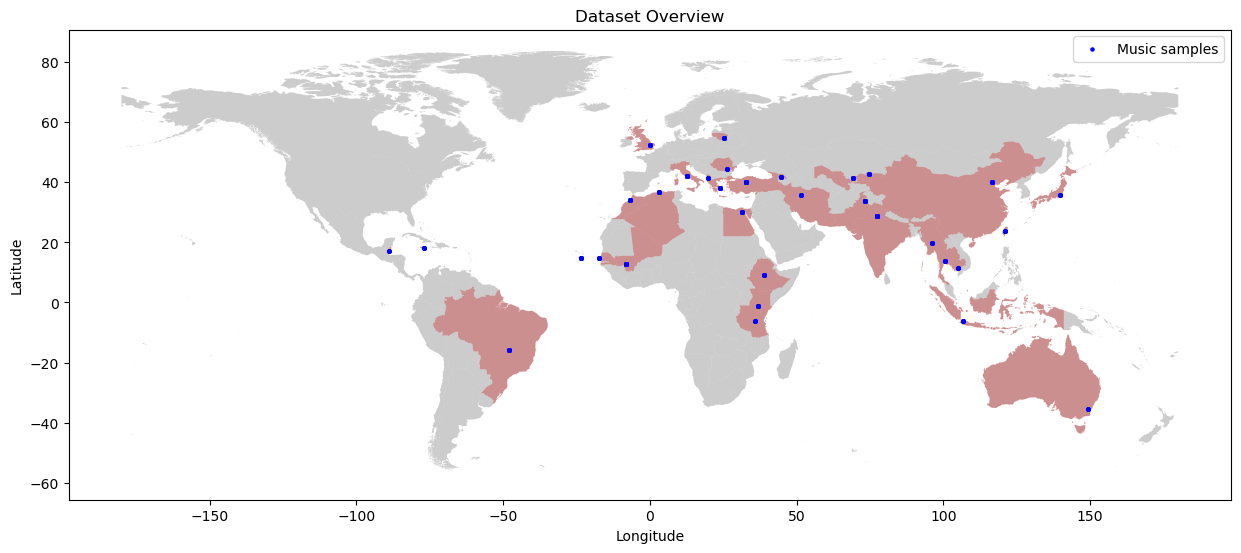

In [5]:
geometry = [Point(xy) for xy in zip(music_origin_data['Longitude'], music_origin_data['Latitude'])]
music_origin_gdf = gpd.GeoDataFrame(music_origin_data, geometry=geometry, crs="EPSG:4326")
music_origin_gdf = gpd.sjoin(music_origin_gdf, gdf_bondaries, how="left", op="within")
unmatched_points = music_origin_gdf[music_origin_gdf['iso3'].isna()].copy()

for idx, point in unmatched_points.iterrows():
    point_geom = point['geometry']
    nearest_polygon_idx = gdf_bondaries.geometry.distance(point_geom).idxmin()
    nearest_polygon_attributes = gdf_bondaries.loc[nearest_polygon_idx]
    nearest_polygon_attributes['geometry'] = point_geom
    music_origin_gdf.loc[idx, music_origin_gdf.columns.intersection(nearest_polygon_attributes.index)] = nearest_polygon_attributes

music_origin_gdf = music_origin_gdf.drop(columns=['index_right']).rename(columns={'index_left': 'index'})


plt.figure(figsize=(15,10))
music_origin_gdf_filtered = gdf_bondaries[gdf_bondaries['iso3'].isin(music_origin_gdf['iso3'])]
music_origin_gdf_filtered.plot(ax=plt.gca(), color='red', alpha=0.4, label='Shapefile')
gdf_bondaries.plot(ax=plt.gca(), color='gray', alpha=0.4, label='Shapefile')
plt.scatter(music_origin_data["Longitude"], music_origin_data["Latitude"], s=5, color = "blue",label = 'Music samples')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Dataset Overview')
plt.legend()
plt.savefig('./images/01_Dataset_overview.png')
plt.show()

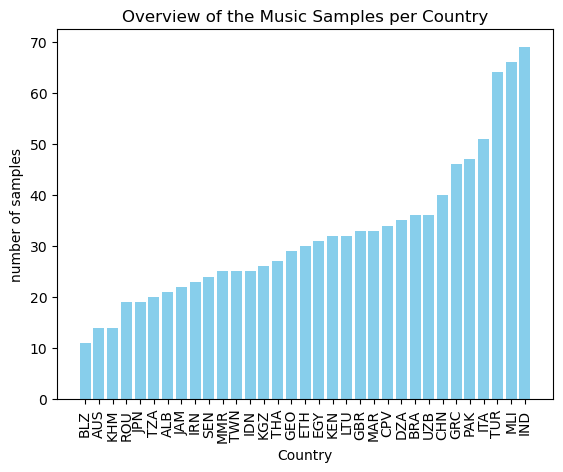

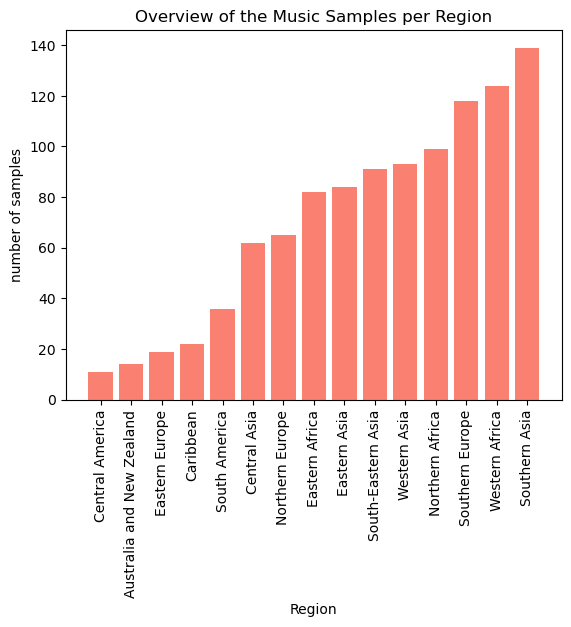

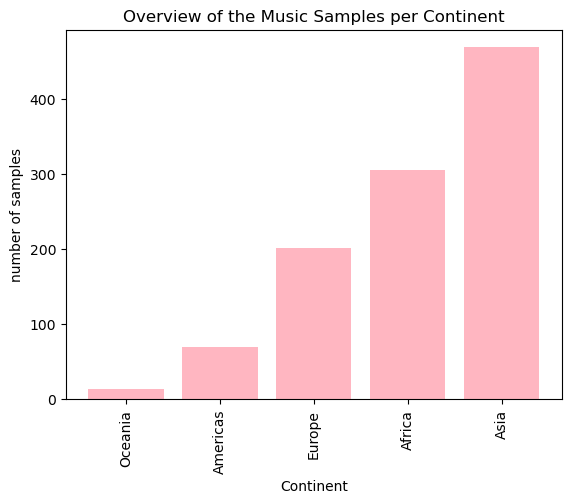

In [6]:
per_country = music_origin_gdf.groupby('iso3').nunique().reset_index().sort_values('Feature1')
plt.bar(per_country["iso3"],per_country["Feature1"], color = "skyblue")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per Country")
plt.ylabel("number of samples")
plt.xlabel("Country")
plt.savefig('./images/04_Overview_music_per_country.png')
plt.show()

per_region = music_origin_gdf.groupby('region').nunique().reset_index().sort_values('Feature1')
plt.bar(per_region["region"],per_region["Feature1"], color = "salmon")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per Region")
plt.ylabel("number of samples")
plt.xlabel("Region")
plt.savefig('./images/05_Overview_music_per_region.png')
plt.show()

per_continent = music_origin_gdf.groupby('continent').nunique().reset_index().sort_values('Feature1')
plt.bar(per_continent["continent"],per_continent["Feature1"], color = "lightpink")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per Continent")
plt.ylabel("number of samples")
plt.xlabel("Continent")
plt.savefig('./images/06_Overview_music_per_continent.png')
plt.show()

# Have a Look at the 68 Features

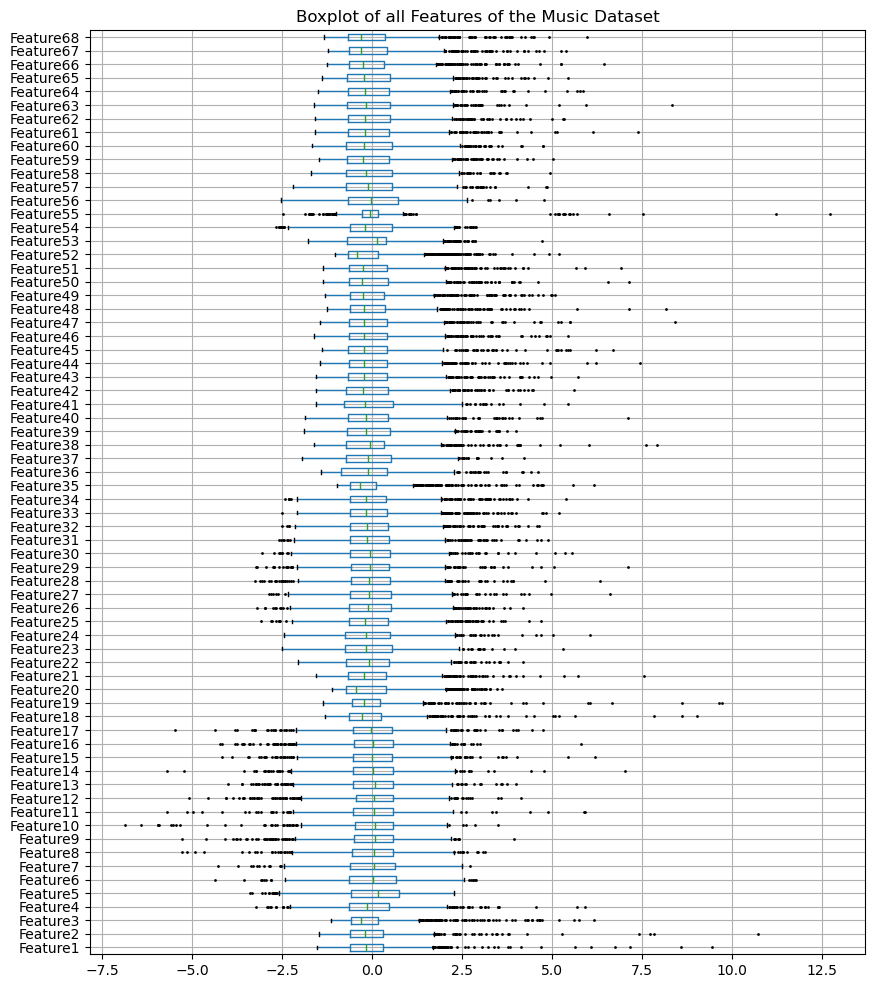

In [7]:
plt.figure(figsize=(10, 12))
music_origin_gdf.drop(['Latitude', 'Longitude', 'geometry', 'iso3',
                        'status', 'color_code', 'name', 'continent', 'region', 'iso_3166_1_',
                        'french_shor'],axis=1).boxplot(vert=False,
                                                       flierprops={'marker': 'o', 'markersize': 1})

plt.title("Boxplot of all Features of the Music Dataset")
plt.savefig('./images/07_Boxplot_68Features.png')

There are alot of features, thus it could be an idea, to make a Principle Component Analysis to reduce the number of features.

# Preprocessing

In [8]:
#make PCA:
scaler = preprocessing.StandardScaler()
music_origin_gdf_scaled = scaler.fit_transform(music_origin_gdf.drop(['Latitude', 'Longitude', 'geometry', 'iso3',
                                                                      'status', 'color_code', 'name', 'continent', 'region', 'iso_3166_1_',
                                                                      'french_shor'],axis=1))
nums = np.arange(68)
var_ratio = []
for num in nums:
    pca = PCA(n_components=num).fit(music_origin_gdf_scaled)
    var_ratio.append(np.sum(pca.explained_variance_ratio_))

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check 

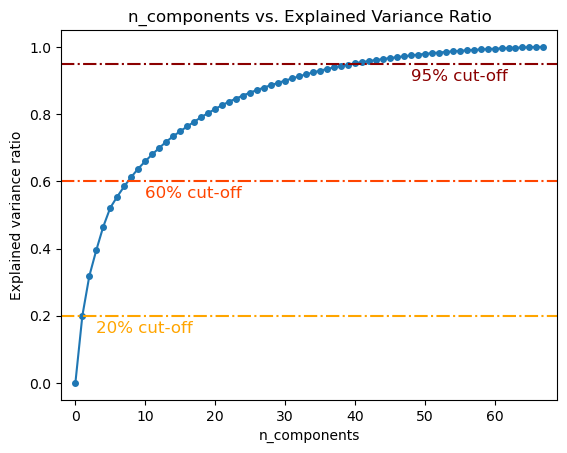

In [9]:
plt.plot(nums,var_ratio,marker='o',markersize = 4)
plt.xlim(-2,69)
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')
plt.axhline(y=0.95, color='darkred', linestyle='-.')
plt.text(48, 0.9, '95% cut-off', color = 'darkred', fontsize=12)
plt.axhline(y=0.6, color='orangered', linestyle='-.')
plt.text(10, 0.55, '60% cut-off ', color = 'orangered', fontsize=12)
plt.axhline(y=0.2, color='orange', linestyle='-.')
plt.text(3, 0.15, '20% cut-off', color = 'orange', fontsize=12)
plt.savefig('./images/08_PCA_n_comp_vs_variance3.png')

In [10]:
music_origin_gdf_filtered = music_origin_gdf_filtered.merge(music_origin_gdf["iso3"],on = "iso3")
music_origin_gdf_filtered["iso3"].unique()

array(['DZA', 'JAM', 'BLZ', 'MAR', 'TUR', 'LTU', 'UZB', 'CPV', 'ITA',
       'IRN', 'ETH', 'KGZ', 'GBR', 'SEN', 'GRC', 'IDN', 'PAK', 'EGY',
       'IND', 'THA', 'AUS', 'TWN', 'BRA', 'KHM', 'GEO', 'CHN', 'ROU',
       'TZA', 'MMR', 'JPN', 'MLI', 'ALB', 'KEN'], dtype=object)

Okay, we choose the 95% cut-off beacuse then we have 95% of the variance explained, which is quite good.

Number of components to reach 95% cutoff: 41
Number of components to reach 60% cutoff: 9
Number of components to reach 20% cutoff: 3


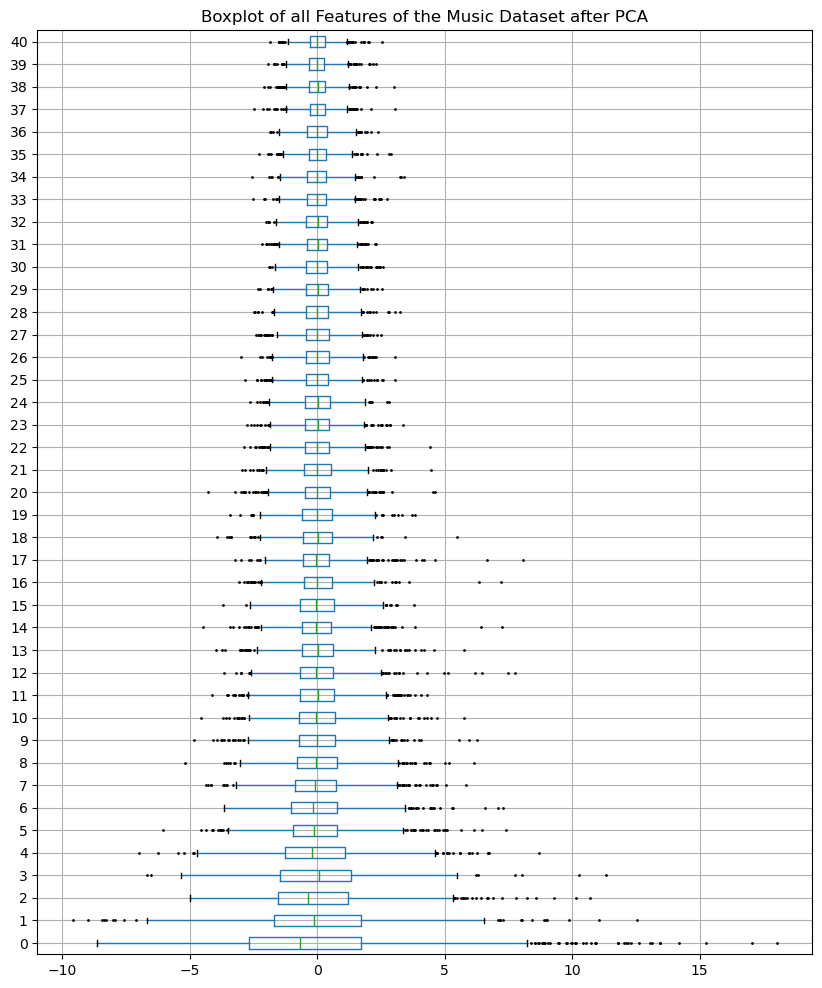

In [11]:
def get_num_components(percent,var_ratio = var_ratio):
    num_components_XX_percent = np.argmax(np.array(var_ratio) >= percent/100) + 1
    #print(f"Number of components to reach {percent}% cutoff: {num_components_XX_percent}")
    return num_components_XX_percent

print(f"Number of components to reach 95% cutoff: {get_num_components(95)}")
print(f"Number of components to reach 60% cutoff: {get_num_components(60)}")
print(f"Number of components to reach 20% cutoff: {get_num_components(20)}")

#make PCA with 95% cutoff
music_origin_pca= pd.DataFrame(PCA(n_components=get_num_components(95)).fit_transform(music_origin_gdf_scaled))
music_origin_gdf_pca = music_origin_pca.merge(music_origin_gdf.loc[:,['Latitude', 'Longitude', 'iso3',
                                                                          'status', 'color_code', 'name', 'continent', 'region', 'iso_3166_1_',
                                                                          'french_shor']], left_index=True, right_index=True)


plt.figure(figsize=(10, 12))
music_origin_pca.boxplot(vert=False, flierprops={'marker': 'o', 'markersize': 1})

plt.title("Boxplot of all Features of the Music Dataset after PCA")
plt.savefig('./images/09_Boxplot_68Features_PCA.png')


# Clustering

To make this problem to a classification problem, we have to define clusters in order to classify the music samples

## Manual Clustering (geographic boundaries made by humans)

In [12]:
#By region
gdf_regions = gdf_bondaries.dissolve(by='region')
gdf_regions["region"] = gdf_regions.index
gdf_regions1 = gdf_regions[gdf_regions["region"].isin(music_origin_gdf_pca.region.unique())]

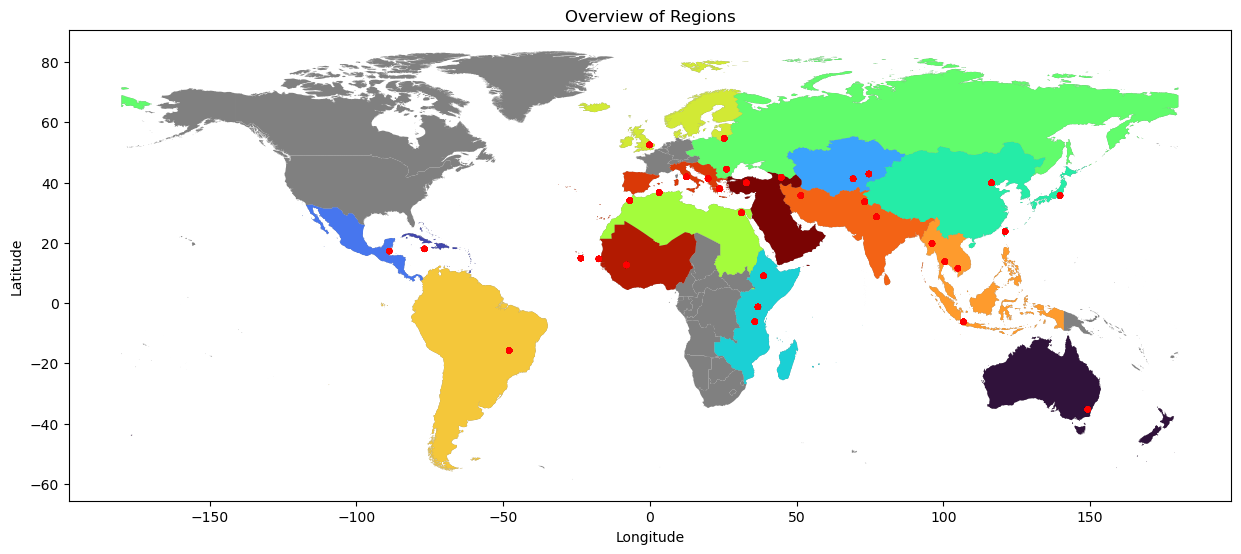

In [13]:
plt.figure(figsize=(15,10))
gdf_bondaries.plot(ax=plt.gca(), color = "gray",edgecolor = "none")
gdf_regions1.plot(ax=plt.gca(), column='region', cmap="turbo", alpha=1, legend=False, label='World Regions',edgecolor = "none")
plt.scatter(music_origin_data["Longitude"], music_origin_data["Latitude"], s=20, color = "red",label = 'Music samples',edgecolor = "none")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.gca().set_facecolor("")
plt.grid(False)
plt.title("Overview of Regions")
plt.savefig('./images/10_Clustering_region.png')

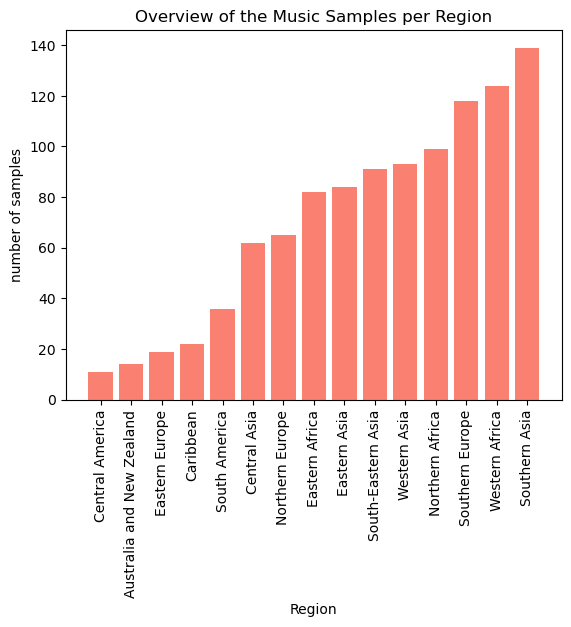

In [14]:
per_region = music_origin_gdf_pca.groupby('region').nunique().reset_index().sort_values(1)
plt.bar(per_region["region"],per_region[1], color = "salmon")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per Region")
plt.ylabel("number of samples")
plt.xlabel("Region")
plt.show()


music_origin_gdf_pca_manual = music_origin_gdf_pca.copy()
music_origin_gdf_pca_manual["Cluster"] = music_origin_gdf_pca_manual["region"]

As seen here, we can see that the clusters are not equally distributed, which can lead to a false good prediction, because the chances that it lies in southern Asia is about the same. We try now to DBSCAN the points to clusters.

## Automatic Clustering (DBScan Method)

In [15]:
# Standardize the data
scaler = preprocessing.StandardScaler()
scaled_data = scaler.fit_transform(music_origin_gdf_pca[["Longitude","Latitude"]])
dbscan = DBSCAN(eps=0.5, min_samples=2)  # You may need to adjust eps and min_samples
music_origin_gdf_pca_dbscan = music_origin_gdf_pca.copy()
music_origin_gdf_pca_dbscan["Cluster"] = dbscan.fit_predict(scaled_data)

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check 

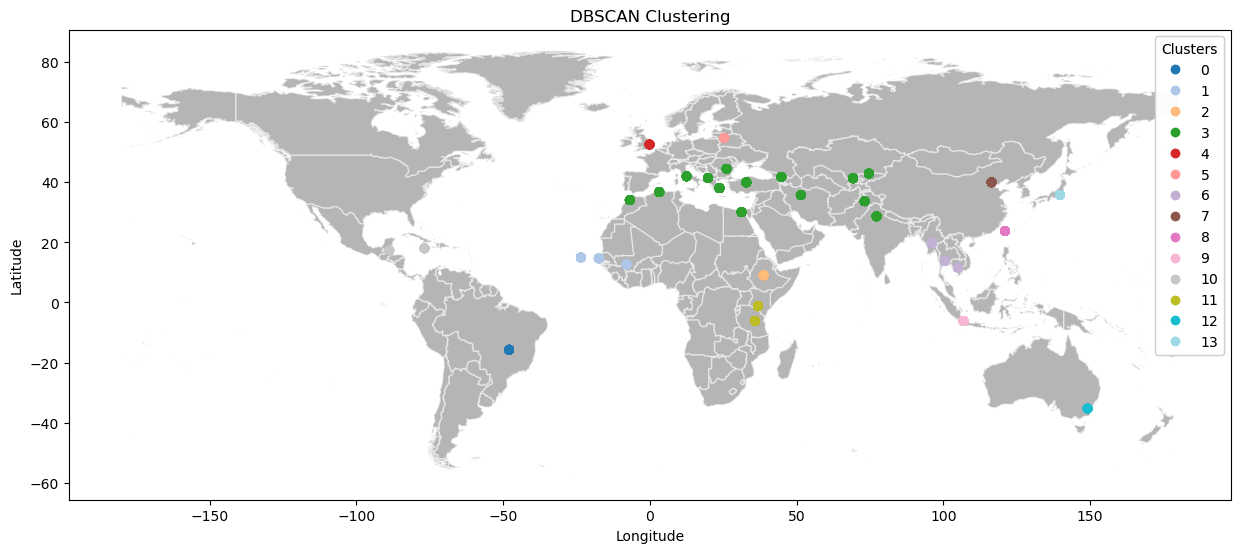

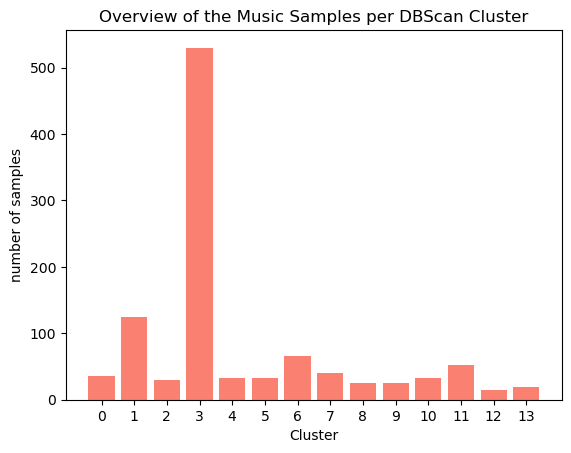

In [16]:
plt.figure(figsize=(15,10))
gdf_bondaries.plot(ax=plt.gca(), alpha=0.5, color = "#6d6d6d",edgecolor = "white")
scatter = plt.scatter(music_origin_gdf['Longitude'], music_origin_gdf['Latitude'], c=music_origin_gdf_pca_dbscan['Cluster'], cmap='tab20', label='Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering')
legend = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend)  # Add the legend back to the plot
plt.savefig('./images/11_DBSCAN_Clusters.png')
plt.grid(False)
plt.show()

per_DBCluster = music_origin_gdf_pca_dbscan.groupby("Cluster").nunique()[0].reset_index().sort_values(0)
plt.bar(per_DBCluster["Cluster"],per_DBCluster[0], color = "salmon")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per DBScan Cluster")
plt.ylabel("number of samples")
plt.xlabel("Cluster")
plt.xticks(per_DBCluster["Cluster"],rotation = "horizontal")
plt.savefig('./images/12_Overview_DBSCAN_Clusters.png')

plt.show()

# Classification internal data structure cluster

In [17]:
music_origin_gdf_pca_kmeans = music_origin_gdf_pca.copy()
selected_columns = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                    16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                    30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
selected_df = music_origin_gdf_pca_kmeans.iloc[:, selected_columns]

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(selected_df)
music_origin_gdf_pca_kmeans['Cluster'] = kmeans.labels_


C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set 

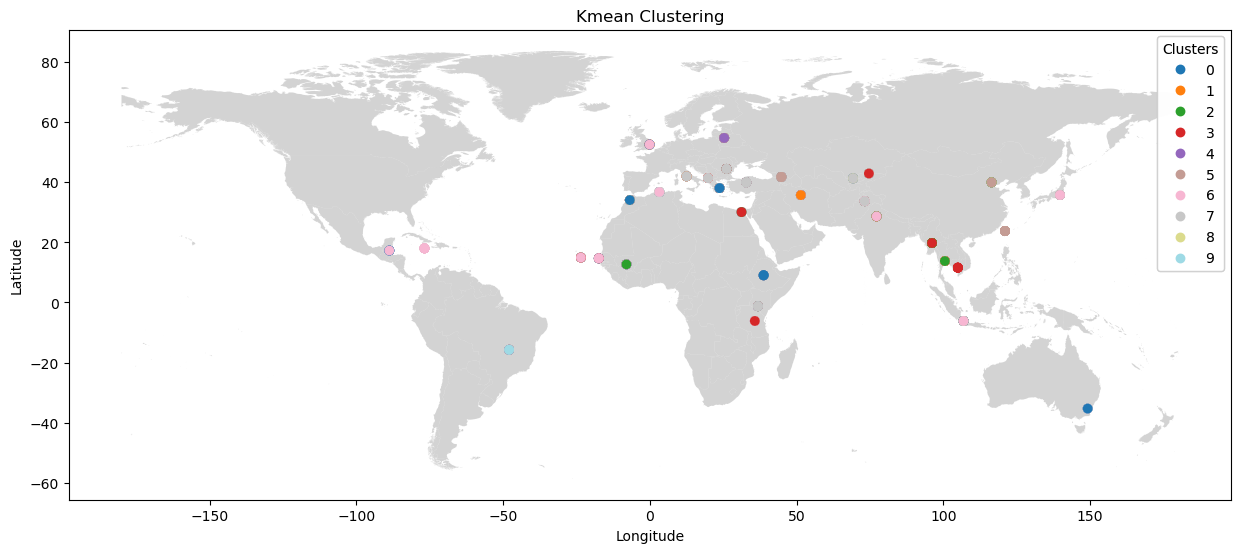

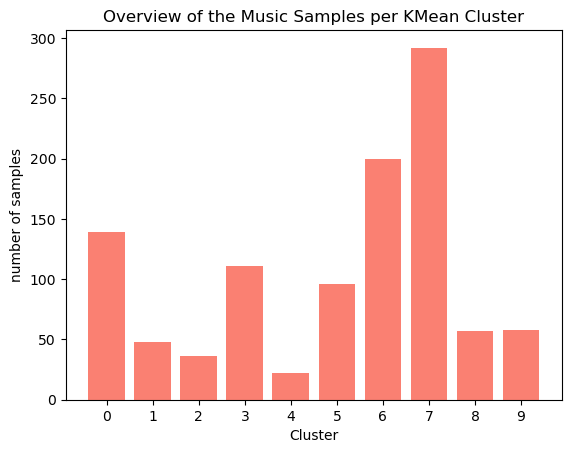

In [18]:
plt.figure(figsize=(15,10))
gdf_bondaries.plot(ax=plt.gca(), alpha=0.5, color = "darkgrey",edgecolor = "none")
scatter = plt.scatter(music_origin_gdf['Longitude'], music_origin_gdf['Latitude'], c=music_origin_gdf_pca_kmeans['Cluster'], cmap='tab20', label='Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Kmean Clustering')
legend = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend)  # Add the legend back to the plot
plt.savefig('./images/11_KMeans_clusters.png')
plt.show()

per_KmeanCluster = music_origin_gdf_pca_kmeans.groupby("Cluster").nunique()[0].reset_index().sort_values(0)
plt.bar(per_KmeanCluster["Cluster"],per_KmeanCluster[0], color = "salmon")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per KMean Cluster")
plt.ylabel("number of samples")
plt.xlabel("Cluster")
plt.xticks(per_KmeanCluster["Cluster"],rotation = "horizontal")
plt.savefig('./images/12_Overview_DBSCAN_Clusters.png')

# Defining ML Technique

In [19]:
scorer = make_scorer(accuracy_score)
rfc = cb.CatBoostClassifier()
param_grid = {
    'iterations': [350],
    'depth': [6],
    'learning_rate': [0.2]
}

grid_search = GridSearchCV(
    estimator=rfc,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    n_jobs=-1,
    refit='mse',
    verbose=10,
)

# Defining final matrix

In [20]:
final_matrix = pd.DataFrame(columns = ["score","ML_Clustering_Manual_PCA","ML_Clustering_DBScan_PCA","ML_Clustering_KMeans_PCA","ML_Clustering_Manual_SMOTE","ML_Clustering_DBScan_SMOTE","ML_Clustering_KMeans_SMOTE"],)
final_matrix["score"] = ['Accuracy', 'Precision', 'Recall', 'F1 Score (Weighted)']
final_matrix=final_matrix.set_index("score")

final_matrix

,ML_Clustering_Manual_PCA,ML_Clustering_DBScan_PCA,ML_Clustering_KMeans_PCA,ML_Clustering_Manual_SMOTE,ML_Clustering_DBScan_SMOTE,ML_Clustering_KMeans_SMOTE
score,,,,,,
Accuracy,NaN,NaN,NaN,NaN,NaN,NaN
Precision,NaN,NaN,NaN,NaN,NaN,NaN
Recall,NaN,NaN,NaN,NaN,NaN,NaN
F1 Score (Weighted),NaN,NaN,NaN,NaN,NaN,NaN


# Training (With PCA)

In [21]:
#1. define the ML Technique:
names = ["ML_Clustering_Manual", "ML_Clustering_DBScan", "ML_Clustering_KMeans"]

#2. define all Clustering methods (wihtout SMOTE)
ML_Clustering_Manual = music_origin_gdf_pca_manual.drop(['Latitude', 'Longitude',
                                                         'status', 'color_code', 'name', 'iso3', 'iso_3166_1_',
                                                         'french_shor','continent','region'],axis = 1)

ML_Clustering_DBScan = music_origin_gdf_pca_dbscan.drop(['Latitude', 'Longitude',
                                                         'status', 'color_code', 'name', 'iso3', 'iso_3166_1_',
                                                         'french_shor','continent','region'],axis = 1)


ML_Clustering_KMeans = music_origin_gdf_pca_kmeans.drop(['Latitude', 'Longitude',
                                                         'status', 'color_code', 'name', 'iso3', 'iso_3166_1_',
                                                         'french_shor','continent','region'],axis = 1)


-----------------------------
Name of Clustering:
 ML_Clustering_Manual
Cluster
Southern Asia                139
Western Africa               124
Southern Europe              118
Northern Africa               99
Western Asia                  93
South-Eastern Asia            91
Eastern Asia                  84
Eastern Africa                82
Northern Europe               65
Central Asia                  62
South America                 36
Caribbean                     22
Eastern Europe                19
Australia and New Zealand     14
Central America               11
Name: count, dtype: int64
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

0:	learn: 2.6258631	total: 169ms	remaining: 58.9s
1:	learn: 2.5570219	total: 199ms	remaining: 34.7s
2:	learn: 2.4789326	total: 230ms	remaining: 26.6s
3:	learn: 2.4095255	total: 258ms	remaining: 22.3s
4:	learn: 2.3487086	total: 287ms	remaining: 19.8s
5:	learn: 2.2800076	total: 316ms	remaining: 18.1s
6:	learn: 2.2292775	total: 344ms	remaining: 16.9s
7:	learn: 2.1861733	total: 374ms	remaining: 16s
8:	learn: 2.1407303	total: 405ms	remaining: 15.3s
9:	learn: 2.0917627	total: 437ms	remaining: 14.8s
10:	learn: 2.0433241	total: 467ms	remaining: 14.4s
11:	learn: 1.9952702	total: 496ms	remaining: 14s
12:	learn: 1.9605887	total: 526ms	remaining: 13.6s
13:	learn: 1.9184395	total: 554ms	remaining: 13.3s
14:	learn: 1.8740971	total: 583ms	remaining: 13s
15:	learn: 1.8454023	total: 615ms	remaining: 12.8s
16:	learn: 1.8052211	total: 646ms	remaining: 12.7s
17:	learn: 1.7633044	total: 677ms	remaining: 12.5s
18:	learn: 1.7238494	total: 707ms	remaining: 12.3s
19:	learn: 1.6840971	total: 737ms	remaining: 12

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

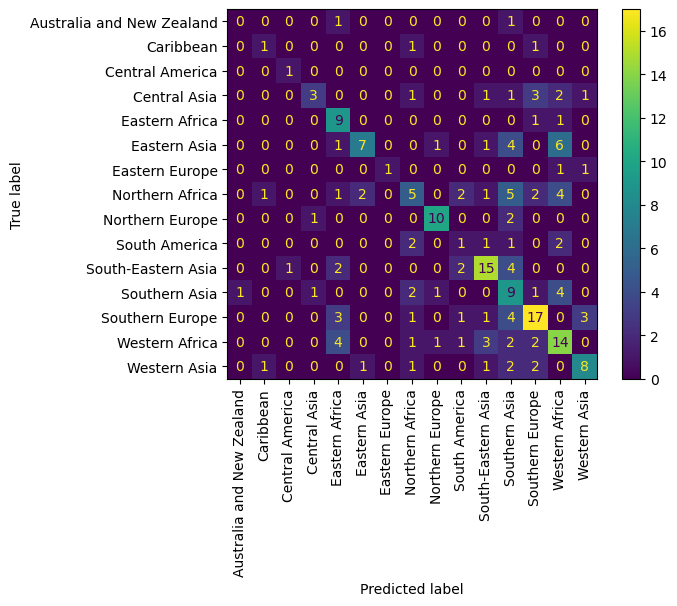

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

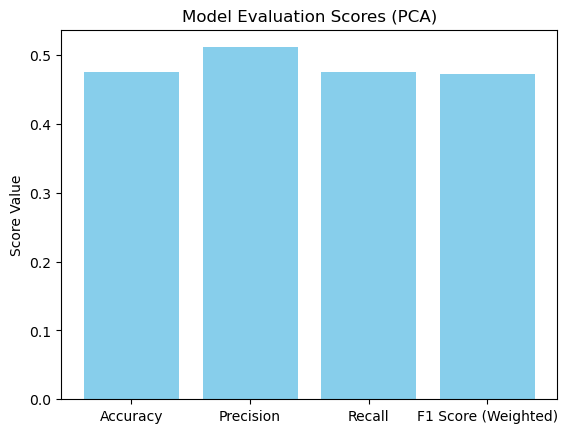

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

-----------------------------
-----------------------------
Name of Clustering:
 ML_Clustering_DBScan
Cluster
3     530
1     124
6      66
11     52
7      40
0      36
4      33
10     33
5      32
2      30
8      25
9      25
13     19
12     14
Name: count, dtype: int64
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 2.4087353	total: 26.6ms	remaining: 9.29s
1:	learn: 2.1961967	total: 51.7ms	remaining: 8.99s
2:	learn: 2.0466154	total: 78.6ms	remaining: 9.1s
3:	learn: 1.9465550	total: 103ms	remaining: 8.93s
4:	learn: 1.8530749	total: 129ms	remaining: 8.87s
5:	learn: 1.7816509	total: 158ms	remaining: 9.07s
6:	learn: 1.6966322	total: 185ms	remaining: 9.08s
7:	learn: 1.6468272	total: 211ms	remaining: 9.03s
8:	learn: 1.6000687	total: 238ms	remaining: 9s
9:	learn: 1.5504646	total: 264ms	remaining: 8.98s
10:	learn: 1.5095488	total: 290ms	remaining: 8.92s
11:	learn: 1.4702417	total: 318ms	remaining: 8.95s
12:	learn: 1.4350958	total: 348ms	remaining: 9.01s
13:	learn: 1.

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

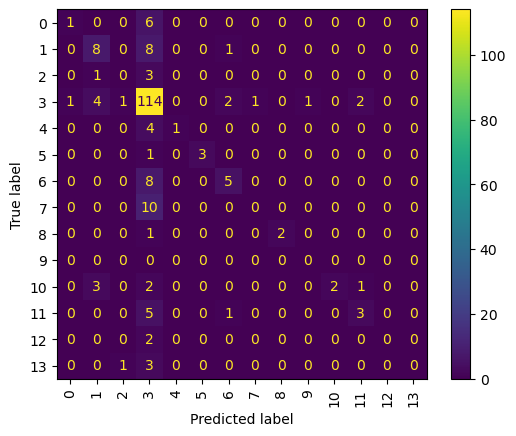

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

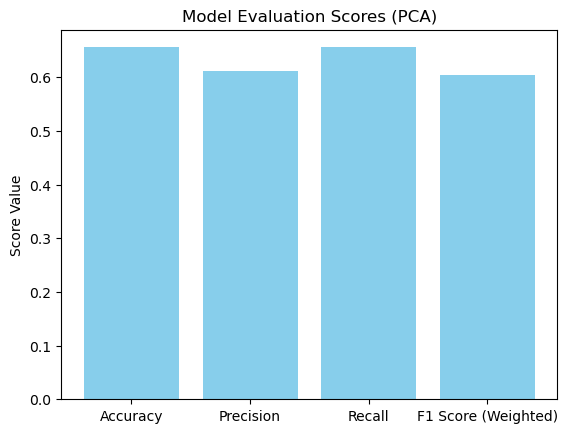

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

-----------------------------
-----------------------------
Name of Clustering:
 ML_Clustering_KMeans
Cluster
7    292
6    200
0    139
3    111
5     96
9     58
8     57
1     48
2     36
4     22
Name: count, dtype: int64
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 1.8895042	total: 18.3ms	remaining: 6.38s
1:	learn: 1.6577709	total: 37.2ms	remaining: 6.48s
2:	learn: 1.5201224	total: 54.8ms	remaining: 6.33s
3:	learn: 1.3826384	total: 71.6ms	remaining: 6.19s
4:	learn: 1.2927367	total: 89.4ms	remaining: 6.17s
5:	learn: 1.1758805	total: 106ms	remaining: 6.1s
6:	learn: 1.0918917	total: 125ms	remaining: 6.1s
7:	learn: 1.0083683	total: 142ms	remaining: 6.09s
8:	learn: 0.9498952	total: 160ms	remaining: 6.05s
9:	learn: 0.8882228	total: 182ms	remaining: 6.19s
10:	learn: 0.8401532	total: 199ms	remaining: 6.14s
11:	learn: 0.8039865	total: 217ms	remaining: 6.11s
12:	learn: 0.7548882	total: 234ms	remaining: 6.08s
13:	learn: 0.7187357	total: 252ms	remaining: 6.04s
14:	lear

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

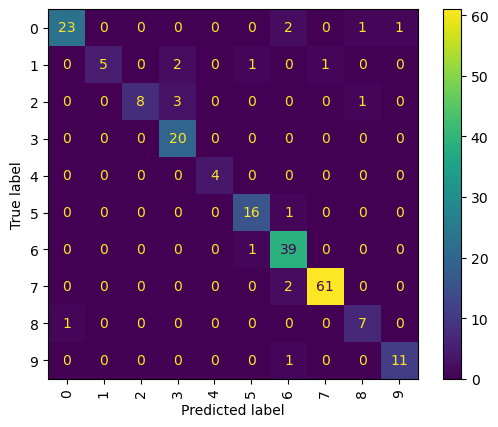

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

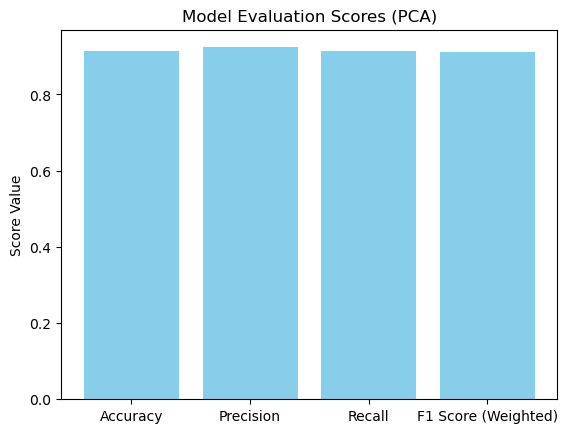

-----------------------------


In [22]:
num = 0

#loop through all of them
for i in [ML_Clustering_Manual,ML_Clustering_DBScan,ML_Clustering_KMeans]:
    print(f"-----------------------------\nName of Clustering:\n {names[num]}")
    print(i["Cluster"].value_counts())
    start_time = datetime.now()
    X_train, X_test, y_train, y_test = train_test_split(i.drop("Cluster",axis = 1), i['Cluster'], test_size=0.2)

    grid_search.fit(X_train,y_train)
    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_
    end_time = datetime.now()
    print(f'Finished in: {end_time-start_time}')
    best_params = grid_search.best_params_
    best_accuracy = grid_search.best_score_
    print("Best Parameters:", best_params)
    print("Best Accuracy Score:", best_accuracy)


    y_pred = grid_search.best_estimator_.predict(X_test)
    f1_score(y_test,y_pred,average='weighted')

    ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test)
    plt.xticks(rotation=90)  # Set the desired rotation angle
    plt.show()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    final_matrix.at["Accuracy", f"{names[num]}_PCA"] = accuracy
    final_matrix.at["Precision", f"{names[num]}_PCA"] = precision
    final_matrix.at["Recall", f"{names[num]}_PCA"] = recall
    final_matrix.at["F1 Score (Weighted)", f"{names[num]}_PCA"] = f1





    scores = [accuracy, precision, recall, f1]
    score_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score (Weighted)']

    plt.bar(score_names, scores, color='skyblue')
    plt.title('Model Evaluation Scores (PCA)')
    plt.ylabel('Score Value')
    plt.show()
    num +=1

    print("-----------------------------")

# With SMOTE

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Cluster
Southern Asia                139
Western Africa               124
Southern Europe              118
Northern Africa               99
Western Asia                  93
South-Eastern Asia            91
Eastern Asia                  84
Eastern Africa                82
Northern Europe               65
Central Asia                  62
South America                 36
Caribbean                     22
Eastern Europe                19
Australia and New Zealand     14
Central America               11
Name: count, dtype: int64


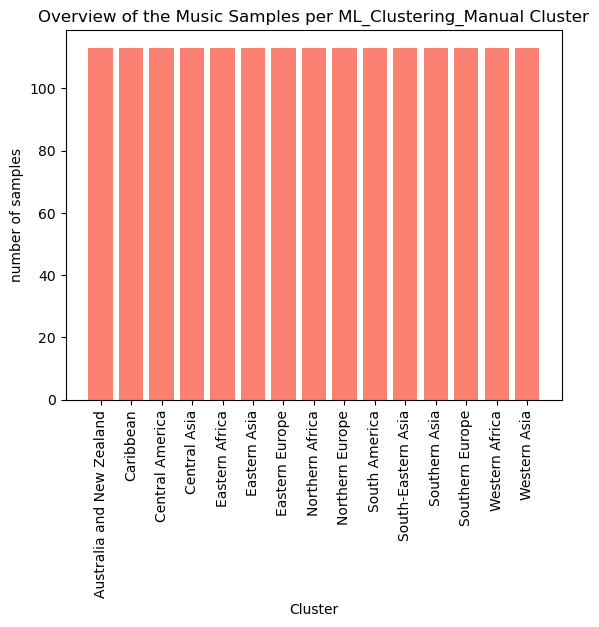

Cluster
3     530
1     124
6      66
11     52
7      40
0      36
4      33
10     33
5      32
2      30
8      25
9      25
13     19
12     14
Name: count, dtype: int64


C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

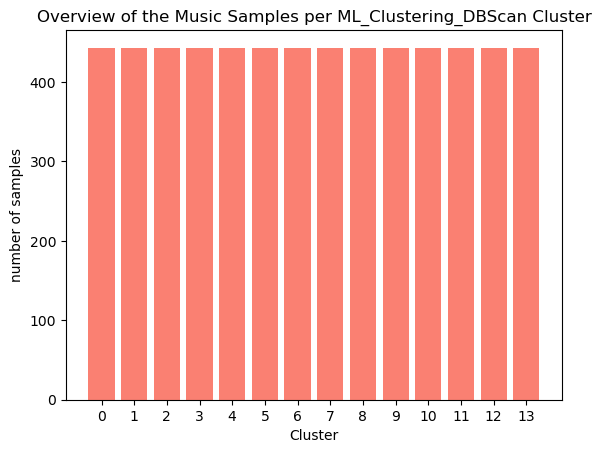

Cluster
7    292
6    200
0    139
3    111
5     96
9     58
8     57
1     48
2     36
4     22
Name: count, dtype: int64


C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

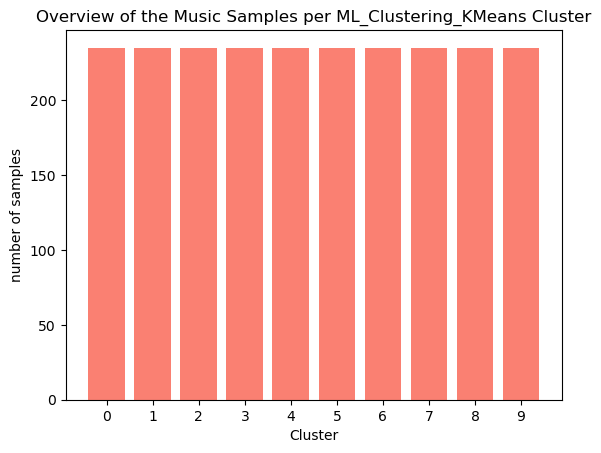

In [23]:
#Smote visualisation for paper:
num = 0

for i in [ML_Clustering_Manual,ML_Clustering_DBScan,ML_Clustering_KMeans]:
    print(i["Cluster"].value_counts())
    X_train, X_test, y_train, y_test = train_test_split(i.drop("Cluster",axis = 1), i['Cluster'], test_size=0.2)
    smote = SMOTE(sampling_strategy='auto')
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    per_cluster_resampled = pd.Series(y_train_resampled).value_counts().sort_index()

    plt.bar(per_cluster_resampled.index, per_cluster_resampled.values, color="salmon")
    plt.xticks(rotation='vertical')
    plt.title(f"Overview of the Music Samples per {names[num]} Cluster")
    plt.ylabel("number of samples")
    plt.xlabel("Cluster")
    if num == 0:
        plt.xticks(per_cluster_resampled.index,rotation = "vertical")
    else:
        plt.xticks(per_cluster_resampled.index,rotation = "horizontal")
    plt.show()
    num +=1



Cluster
Southern Asia                139
Western Africa               124
Southern Europe              118
Northern Africa               99
Western Asia                  93
South-Eastern Asia            91
Eastern Asia                  84
Eastern Africa                82
Northern Europe               65
Central Asia                  62
South America                 36
Caribbean                     22
Eastern Europe                19
Australia and New Zealand     14
Central America               11
Name: count, dtype: int64


C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 2.4900002	total: 27.3ms	remaining: 9.52s
1:	learn: 2.3015643	total: 56.8ms	remaining: 9.88s
2:	learn: 2.1605868	total: 85.7ms	remaining: 9.91s
3:	learn: 2.0246858	total: 112ms	remaining: 9.71s
4:	learn: 1.9457690	total: 139ms	remaining: 9.58s
5:	learn: 1.8710140	total: 166ms	remaining: 9.51s
6:	learn: 1.7772381	total: 197ms	remaining: 9.64s
7:	learn: 1.7218658	total: 224ms	remaining: 9.57s
8:	learn: 1.6599269	total: 251ms	remaining: 9.53s
9:	learn: 1.5883640	total: 281ms	remaining: 9.56s
10:	learn: 1.5184460	total: 309ms	remaining: 9.51s
11:	learn: 1.4600827	total: 340ms	remaining: 9.56s
12:	learn: 1.4084638	total: 367ms	remaining: 9.52s
13:	learn: 1.3689263	total: 393ms	remaining: 9.44s
14:	learn: 1.3223560	total: 419ms	remaining: 9.36s
15:	learn: 1.2938754	total: 453ms	remaining: 9.45s
16:	learn: 1.2579214	total: 481ms	remaining: 9.43s
17:	learn: 1.2137202	total: 509ms	remaining: 9.38s
18:	learn: 1.1728151	total: 53

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

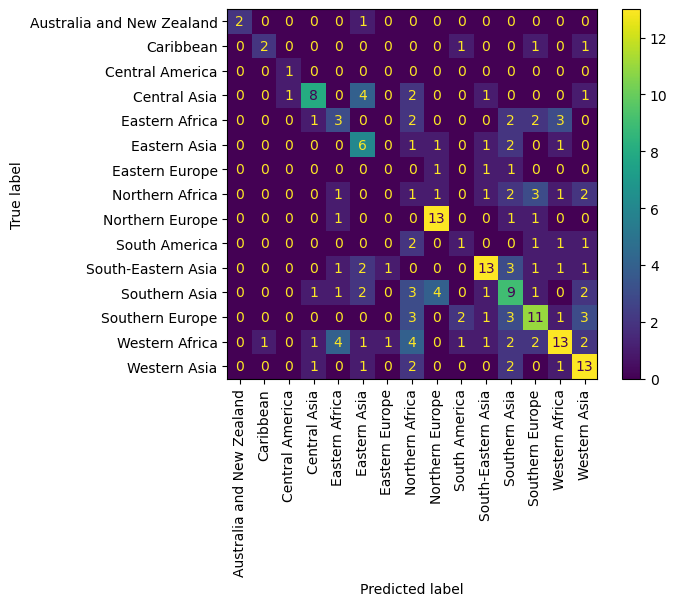

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

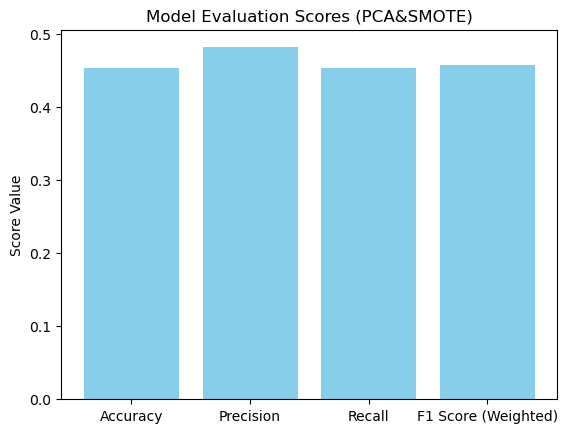

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

-----------------------------
Cluster
3     530
1     124
6      66
11     52
7      40
0      36
4      33
10     33
5      32
2      30
8      25
9      25
13     19
12     14
Name: count, dtype: int64


C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 2.2633485	total: 30.7ms	remaining: 10.7s
1:	learn: 2.0050880	total: 58ms	remaining: 10.1s
2:	learn: 1.8137348	total: 85.9ms	remaining: 9.94s
3:	learn: 1.6282886	total: 112ms	remaining: 9.68s
4:	learn: 1.4762024	total: 139ms	remaining: 9.6s
5:	learn: 1.3763563	total: 167ms	remaining: 9.55s
6:	learn: 1.2832930	total: 196ms	remaining: 9.62s
7:	learn: 1.1795694	total: 224ms	remaining: 9.59s
8:	learn: 1.0903513	total: 253ms	remaining: 9.57s
9:	learn: 1.0060284	total: 280ms	remaining: 9.52s
10:	learn: 0.9395490	total: 308ms	remaining: 9.48s
11:	learn: 0.8822314	total: 334ms	remaining: 9.42s
12:	learn: 0.8289273	total: 365ms	remaining: 9.46s
13:	learn: 0.7859043	total: 392ms	remaining: 9.41s
14:	learn: 0.7419091	total: 419ms	remaining: 9.35s
15:	learn: 0.7043610	total: 445ms	remaining: 9.29s
16:	learn: 0.6694110	total: 473ms	remaining: 9.26s
17:	learn: 0.6281135	total: 504ms	remaining: 9.29s
18:	learn: 0.5941335	total: 530ms

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

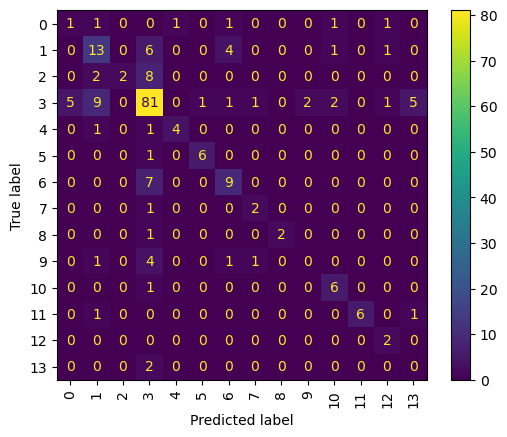

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

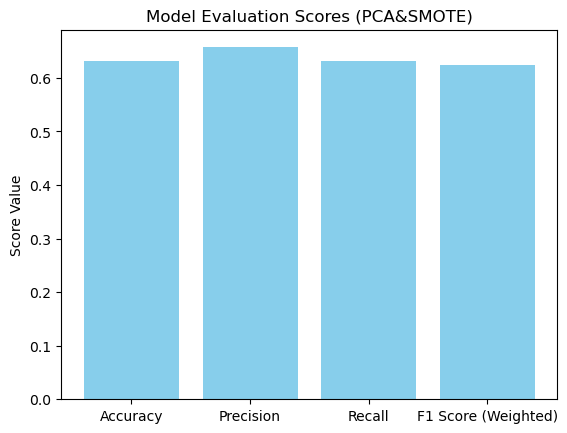

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

-----------------------------
Cluster
7    292
6    200
0    139
3    111
5     96
9     58
8     57
1     48
2     36
4     22
Name: count, dtype: int64


C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 1.6833312	total: 18.3ms	remaining: 6.38s
1:	learn: 1.3781616	total: 40.4ms	remaining: 7.02s
2:	learn: 1.1234809	total: 59.9ms	remaining: 6.93s
3:	learn: 0.9818917	total: 78.7ms	remaining: 6.81s
4:	learn: 0.8498765	total: 96.4ms	remaining: 6.65s
5:	learn: 0.7563837	total: 115ms	remaining: 6.59s
6:	learn: 0.6706364	total: 134ms	remaining: 6.56s
7:	learn: 0.6095018	total: 151ms	remaining: 6.47s
8:	learn: 0.5610284	total: 174ms	remaining: 6.61s
9:	learn: 0.5177513	total: 193ms	remaining: 6.55s
10:	learn: 0.4770114	total: 210ms	remaining: 6.47s
11:	learn: 0.4449189	total: 228ms	remaining: 6.42s
12:	learn: 0.4092812	total: 246ms	remaining: 6.38s
13:	learn: 0.3855337	total: 265ms	remaining: 6.35s
14:	learn: 0.3645809	total: 283ms	remaining: 6.33s
15:	learn: 0.3539227	total: 302ms	remaining: 6.29s
16:	learn: 0.3322386	total: 324ms	remaining: 6.35s
17:	learn: 0.3146902	total: 342ms	remaining: 6.3s
18:	learn: 0.2979236	total: 3

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

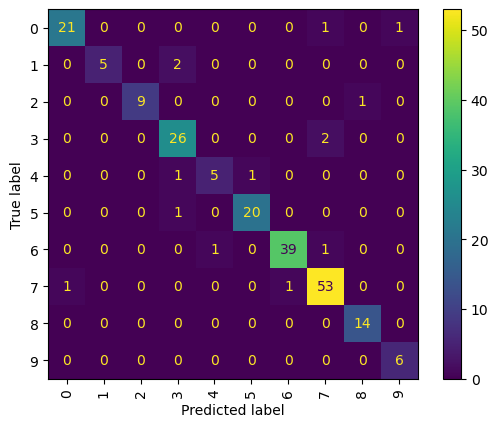

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

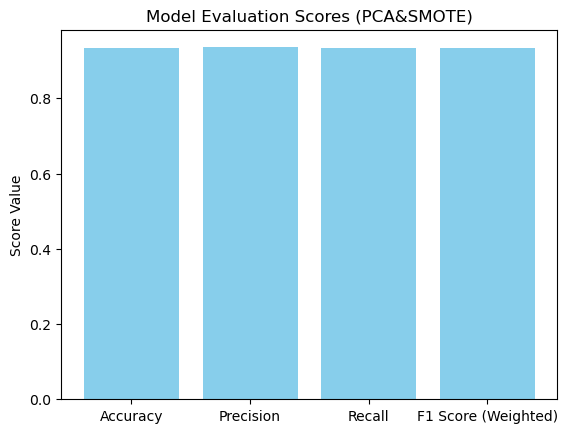

-----------------------------


In [24]:
#the training with the SMOTE Data:
num = 0

for i in [ML_Clustering_Manual,ML_Clustering_DBScan,ML_Clustering_KMeans]:    
    
    print(i["Cluster"].value_counts())
    start_time = datetime.now()
    X_train, X_test, y_train, y_test = train_test_split(i.drop("Cluster",axis = 1), i['Cluster'], test_size=0.2)
    smote = SMOTE(sampling_strategy='auto')
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    
    grid_search.fit(X_train_resampled,y_train_resampled)
    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_
    end_time = datetime.now()
    print(f'Finished in: {end_time-start_time}')
    best_params = grid_search.best_params_
    best_accuracy = grid_search.best_score_
    print("Best Parameters:", best_params)
    print("Best Accuracy Score:", best_accuracy)

    y_pred = grid_search.best_estimator_.predict(X_test)
    f1_score(y_test,y_pred,average='weighted')
    ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test)
    plt.xticks(rotation=90)  # Set the desired rotation angle
    plt.show()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    final_matrix.at["Accuracy", f"{names[num]}_SMOTE"] = accuracy
    final_matrix.at["Precision", f"{names[num]}_SMOTE"] = precision
    final_matrix.at["Recall", f"{names[num]}_SMOTE"] = recall
    final_matrix.at["F1 Score (Weighted)", f"{names[num]}_SMOTE"] = f1


    scores = [accuracy, precision, recall, f1]
    score_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score (Weighted)']

    plt.bar(score_names, scores, color='skyblue')
    plt.title('Model Evaluation Scores (PCA&SMOTE)')
    plt.ylabel('Score Value')
    plt.show()
    num +=1

    print("-----------------------------")

# Presentation / Appendix / Visualisation for explanation

In [25]:
def download_video(url, output_path='./data/'):
    yt = YouTube(url)
    audio_stream = yt.streams.filter(only_audio=True).first()
    audio_stream.download(output_path)
    print(f"Video downloaded successfully to {output_path}")

#download_video(input("Enter the YouTube video URL: "))

# https://stackoverflow.com/questions/55081352/how-to-convert-mp4-to-mp3-using-python
from moviepy.editor import *
def MP4ToMP3(mp4, mp3): 
    FILETOCONVERT = AudioFileClip(mp4)
    FILETOCONVERT.write_audiofile(mp3)
    FILETOCONVERT.close()
VIDEO_FILE_PATH = r"C:\Users\claud\Documents\Studium\GEO871\data\Drums_youtube.mp4"
AUDIO_FILE_PATH =  r"C:\Users\claud\Documents\Studium\GEO871\data\Drums_youtube.mp3"
MP4ToMP3(VIDEO_FILE_PATH, AUDIO_FILE_PATH)    

MoviePy - Writing audio in C:\Users\claud\Documents\Studium\GEO871\data\Drums_youtube.mp3


MoviePy - Done.


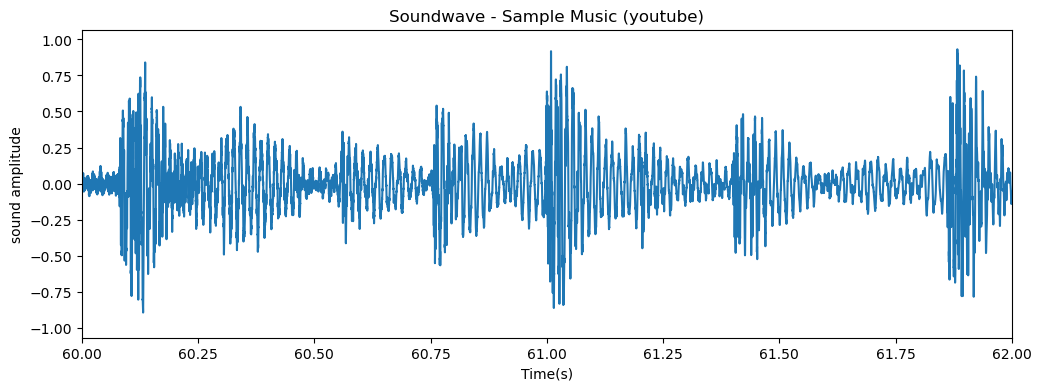

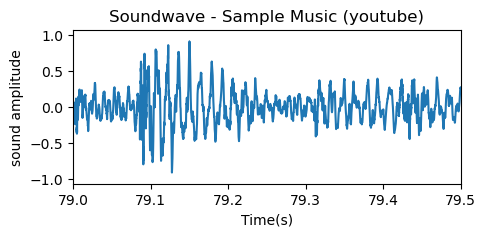

[0.161, 0.164, 0.159, 0.155, 0.148, 0.147, 0.141, 0.137, 0.136, 0.134, 0.135, 0.132, 0.126, 0.122, 0.118, 0.116, 0.116, 0.112, 0.112, 0.12, 0.121, 0.124, 0.126, 0.129, 0.136, 0.135, 0.141, 0.146, 0.15, 0.157, 0.161, 0.165, 0.17, 0.17, 0.175, 0.185, 0.183, 0.181, 0.183, 0.182, 0.195, 0.209, 0.193, 0.18, 0.189, 0.193, 0.186, 0.181, 0.185, 0.185]


In [26]:
def plot_wavelength(audio_file):
    # Load the audio file
    y, sr = librosa.load(audio_file)
    time = np.arange(0,len(y))/sr
    plt.figure(figsize=(12, 4))
    plt.plot(time,y)
    plt.xlim(60,62)
    plt.xlabel("Time(s)")
    plt.ylabel('sound amplitude')
    plt.title("Soundwave - Sample Music (youtube)")
    plt.savefig('./images/13_Soundwave_big.png')
    plt.show()

    plt.figure(figsize=(5, 2))
    plt.plot(time,y)
    plt.xlim(79,79.5)
    plt.xlabel("Time(s)")
    plt.ylabel('sound amplitude')
    plt.title("Soundwave - Sample Music (youtube)")
    plt.savefig('./images/14_Soundwave_small_2.png')
    plt.show()

    
    print(list(np.round(y[5000:5050], 3)))

plot_wavelength(r"C:\Users\claud\Documents\Studium\GEO871\data\Drums_youtube.mp3")

In [27]:
final_matrix

,ML_Clustering_Manual_PCA,ML_Clustering_DBScan_PCA,ML_Clustering_KMeans_PCA,ML_Clustering_Manual_SMOTE,ML_Clustering_DBScan_SMOTE,ML_Clustering_KMeans_SMOTE
score,,,,,,
Accuracy,0.476415,0.65566,0.915094,0.45283,0.632075,0.933962
Precision,0.51168,0.611954,0.923863,0.481489,0.657184,0.935752
Recall,0.476415,0.65566,0.915094,0.45283,0.632075,0.933962
F1 Score (Weighted),0.472798,0.60401,0.912662,0.457896,0.623959,0.933267
